In [5]:
%load_ext autoreload
%autoreload 2
from utils.dataset import Dataset
from utils.dataset_lfw import Dataset as LFW_Dataset
from utils.imageprocessing import preprocess
import model as mlib
from tqdm import tqdm
import torch
import numpy as np

In [6]:
batches = 100

In [7]:
trainset = Dataset("/gpfs/gpfs0/r.karimov/pfe/list_casia_mtcnncaffe_aligned_nooverlap.txt")

In [8]:
batch_format = {
         "size": 128,
         "num_classes": 64,
}
proc_func = lambda images: preprocess(images, True)
trainset.start_batch_queue(batch_format, proc_func=proc_func)

In [91]:
model_dict = torch.load("pfe/sota.pth.tar")

In [92]:
model = dict()
model["backbone"] = mlib.SphereNet20()
model["backbone"].load_state_dict(model_dict["backbone"])
model["uncertain"] = mlib.UncertaintyHead(512)
model["uncertain"].load_state_dict(model_dict["uncertain"])
model["criterion"] = mlib.MLSLoss(mean=False)

In [93]:
model["backbone"] = model["backbone"].cuda()
model["uncertain"] = model["uncertain"].cuda()

In [94]:
paths = LFW_Dataset("/trinity/home/r.karimov/face_uncertainty/pfe-pytorch/Probabilistic-Face-Embeddings/data/lfw_mtcnncaffe_aligned/")['abspath'] 

In [95]:
images = preprocess(paths,  False)
images = torch.from_numpy(images).to(dtype=torch.float32)    
images = images.permute(0, 3, 1, 2)

In [147]:
images.shape

torch.Size([13233, 3, 112, 96])

In [96]:
device = torch.device("cuda")

In [124]:
import cv2
def f(image, k):
    kernel = np.ones((k,k),np.float32)/(k ** 2)
    dst = cv2.filter2D(image,-1,kernel)
    return dst

In [141]:
batch_casia = trainset.pop_batch_queue()

In [156]:
ff_idx = 100
img = images[ff_idx:ff_idx+2]
gty = torch.from_numpy(batch_casia["label"])

In [157]:
ones, fir = [], []
gaus1, gaus2 = [], []
ks = np.linspace(1, 70, 20).astype(np.int)
for i in range(20):
    img1 = img[0]
    img2 = img[1]
    img_1 = f(img1.numpy(), int(ks[i]))
    img_2 = f(img2.numpy(), int(ks[i]))
    
    ad1 = torch.cat((img1[None], torch.from_numpy(img_1[None])), dim=0)
    ad2 = torch.cat((torch.from_numpy(img_1[None]), torch.from_numpy(img_2[None])), dim=0)
    
    feature1, sig_feat1 = model["backbone"](ad1.cuda())
    feature2, sig_feat2 = model["backbone"](ad2.cuda())
    log_sig_sq1 = model["uncertain"](sig_feat1)
    log_sig_sq2 = model["uncertain"](sig_feat2)
    
    dist1 = torch.norm(feature1[0] - feature1[1])
    dist2 = torch.norm(feature2[0] - feature2[1])
    gaus1.append(dist1.item())
    gaus2.append(dist2.item())
    
    loss1 = model["criterion"](feature2, log_sig_sq1, torch.ones(2).cuda())
    loss2 = model["criterion"](feature2, log_sig_sq2, torch.ones(2).cuda())
    ones.append(loss1.item())
    fir.append(loss2.item())

<ipython-input-157-0f4522148cd1>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ks = np.linspace(1, 70, 20).astype(np.int)


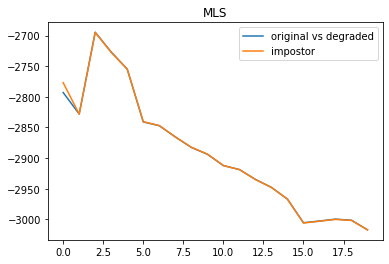

In [158]:
plt.title("MLS")
plt.plot(ones, label="original vs degraded")
plt.plot(fir, label="impostor")
plt.legend()

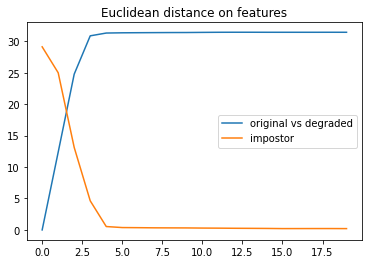

In [159]:
plt.title("Euclidean distance on features")
plt.plot(gaus1, label="original vs degraded")
plt.plot(gaus2, label="impostor")
plt.legend()